# Reduce the resolution of the water mask to match the population

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import rasterio
import xarray as xr
import matplotlib.pyplot as plt
from affine import Affine
from numba import jit
from rasterio import features
from rasterio.crs import CRS
from rasterio.enums import Resampling
from rasterio.warp import reproject

import population_tools
from config import POP_DATA_SRC


In [3]:

def derez_water_mask(file_path, n_iters=1):
    """
    Load water mask and invert such that land is true and water is false
    De rex the water mask by performing 'or' of alternate rows
    and columns such that any point where one square is water (false)
    and the other square is land (true) the resulting point is considered as
    land, since the population may be non-zero.
    
    This is a bit fancier than just performing a decimated read 
    (https://mapbox.github.io/rasterio/topics/resampling.html)
    with the aim of avoiding dropping bits of the population
    """
    with rasterio.open(str(file_path)) as pop:
        print(pop.meta)
        pop_meta = pop.meta
        trns = pop.transform
#         population = pop.read(1, masked=True)
        population = pop.read_masks(1)

        population = population.astype(bool)
    for i in range(n_iters):
        
        first = population[::2, :]
        second = population[1::2, :]
        if second.shape[0] < first.shape[0]:
            # missing a row, need to 'wrap'- just double the values from 'first' as an appoximation
            second = np.vstack((second, first[-1, :]))
        population = first | second
        # Sum every other column
        if second.shape[1] < first.shape[1]:
            # missing a row, need to 'wrap'- just double the values from 'first' as an appoximation
            second = np.hstack((second, first[:, -1]))
        first = population[:, ::2]
        second = population[:, 1::2]
        # population = population[:, ::2] + population[:, 1::2]
        population = first | second
        
        # Output affine scaled by 2
        trns = Affine(trns.a * 2, trns.b, trns.c, trns.d, trns.e * 2, trns.f)
        
    return population, trns, pop_meta
    # Reduction to 1/4 of the original size already makes life much easier


def save_population_geotiff(population, trns, pop_meta):
    print('Saving')
    print(population.shape)
    population = population.astype(float)


    with rasterio.open(str(POP_DATA_SRC / 'nasa_grid' / _POPULATION_PATH_TEMPLATE.format(resolution=REZ_FIX)),
                       'w',
                       driver='GTiff',
                       height=population.shape[0],
                       width=population.shape[1],
                       count=1,
                       dtype='float64',
                       crs=pop_meta['crs'],
                       transform=trns,
                       compress='lzw') as new_dataset:
        new_dataset.write(population, 1)

In [9]:
# REZ_FIX = 'eightres'
REZ_FIX = 'sixteenres'


_POPULATION_PATH_TEMPLATE = 'water_mask_{resolution}.tif'
input_file = POP_DATA_SRC / 'nasa_grid'/ 'gpw-v4-data-quality-indicators-water-mask' / 'gpw-v4-data-quality-indicators_water-mask.tif'
# input_file = (POP_DATA_SRC / 'nasa_grid'/ 'count'/
#               'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-2000' / 
#               'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2000.tif')

In [10]:
population, trns, pop_meta = derez_water_mask(input_file, n_iters=4)


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 43200, 'height': 17400, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.00833333333333339, 0.0, -180.0,
       0.0, -0.008333333333333389, 85.00000000000917)}


In [15]:
save_population_geotiff(population, trns, pop_meta)

Saving
(1088, 2700)


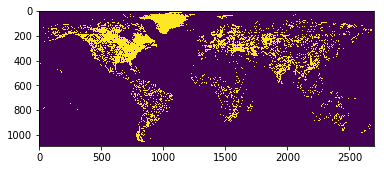

In [5]:
file_path = POP_DATA_SRC / 'water_mask_sixteenres.tif'


with rasterio.open(str(file_path)) as pop:
    pop_mask = pop.read(1)
    plt.imshow(pop_mask)

In [39]:
target = xr.open_dataset(str(POP_DATA_SRC / 'histsoc_population_0.5deg_1861-2005.nc4'), 
                         decode_times=False
                        )
target = target.rename({'lon':'longitude', 'lat':'latitude'})
target

<xarray.Dataset>
Dimensions:           (latitude: 360, longitude: 720, time: 145)
Coordinates:
  * longitude         (longitude) float64 -179.8 -179.2 -178.8 -178.2 -177.8 ...
  * latitude          (latitude) float64 89.75 89.25 88.75 88.25 87.75 87.25 ...
  * time              (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
Data variables:
    number_of_people  (time, latitude, longitude) float64 0.0 0.0 0.0 0.0 ...
Attributes:
    CDI:                       Climate Data Interface version 1.7.2 (http://m...
    Conventions:               CF-1.4
    NCO:                       20161020
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.7.2 (http://m...

In [4]:
# file_path = POP_DATA_SRC / 'water_mask_eightres.tif'
file_path = POP_DATA_SRC / 'water_mask_sixteenres.tif'


with rasterio.open(str(file_path)) as pop:
    pop_mask = pop.read(1)
    aff = pop.transform
    newarr = np.empty(shape=(len(target.latitude),
                         len(target.longitude)))

    newaff = population_tools.get_affine(target)
    
    reproject(
        pop_mask, newarr,
        src_transform = aff,
        dst_transform = newaff,
        src_crs = pop.crs,
        dst_crs = pop.crs,
        resample = Resampling.bilinear)



NameError: name 'target' is not defined

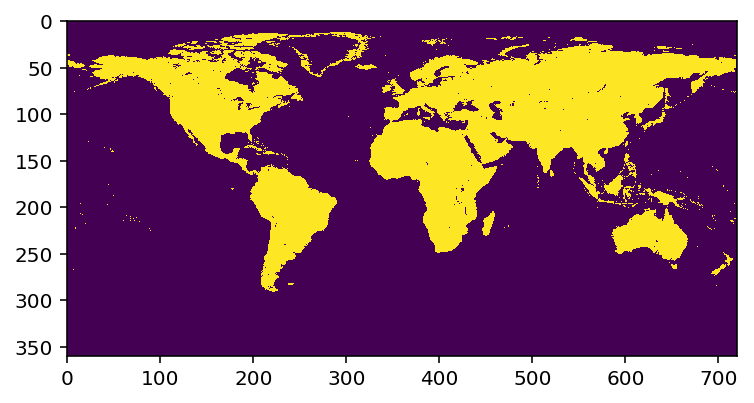

In [35]:
plt.imshow(newarr)